## Import modules

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
%matplotlib inline

In [2]:
seed = 4
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Dataloader

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
)
trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)
testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=50,
                                          shuffle=True,
                                          num_workers=2)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=50,
                                         shuffle=True,
                                         num_workers=2)

In [4]:
# Check batch size and shape of image
for i, (inputs, labels) in enumerate(trainloader, 0):
    print(inputs.size())
    print(labels.size())
    break

torch.Size([50, 1, 28, 28])
torch.Size([50])


## CVAE

In [5]:
class CVAE(nn.Module):
    def __init__(self, z_dim):
        super(CVAE, self).__init__()
        hidden_dim = 512
        self.dense_enc1 = nn.Linear(28*28+10, hidden_dim)
        self.dense_enc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dense_encmean = nn.Linear(hidden_dim, z_dim)
        self.dense_encvar = nn.Linear(hidden_dim, z_dim)
        self.dense_dec1 = nn.Linear(z_dim+10, hidden_dim)
        self.dense_dec2 = nn.Linear(hidden_dim, hidden_dim)
        self.dense_dec3 = nn.Linear(hidden_dim, 28*28)
    
    def _encoder(self, x, l):
#         print(x.size(), l.view(50, 1).size())
#         print(torch.cat([x, l.view(50, 1)],dim=1).size())
        x = torch.cat([x, l], dim=1)
        x = F.relu(self.dense_enc1(x))
        x = F.relu(self.dense_enc2(x))
        mean = self.dense_encmean(x)
        var = F.softplus(self.dense_encvar(x))
        return mean, var
    
    def _sample_z(self, mean, var):
        epsilon = torch.randn(mean.shape).to(device)
        return mean + torch.sqrt(var) * epsilon
 
    def _decoder(self, z, l):
        z = torch.cat([z, l], dim=1)
        x = F.relu(self.dense_dec1(z))
        x = F.relu(self.dense_dec2(x))
        x = torch.sigmoid(self.dense_dec3(x))
        return x

    def forward(self, x, l):
        mean, var = self._encoder(x, l)
        z = self._sample_z(mean, var)
        x = self._decoder(z, l)
        return x, z
    
    def loss(self, x, l):
        mean, var = self._encoder(x, l)
        KL = -0.5 * torch.mean(torch.sum(1 + torch.log(var) - mean**2 - var))
        z = self._sample_z(mean, var)
        y = self._decoder(z, l)
        delta = 1e-6
        reconstruction = torch.mean(torch.sum(x * torch.log(y + delta) + (1 - x) * torch.log(1 - y + delta)))
        lower_bound = [-KL, reconstruction]                                      
        return -sum(lower_bound)

In [6]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())

True
0


In [7]:
device = torch.device("cuda:0")
model = CVAE(10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
losses = []
for i in range(20):
    for x, t in trainloader:
        x = x.to(device)
        t = t.to(device)
        onehot = torch.LongTensor(len(x), 10).zero_().to(device)
        t = t.view(-1, 1)
        t = onehot.scatter(1, t, 1)
        x = x.view(-1, 28 * 28)
        model.zero_grad()
        y = model(x, t)
        loss = model.loss(x, t)
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().detach().numpy())

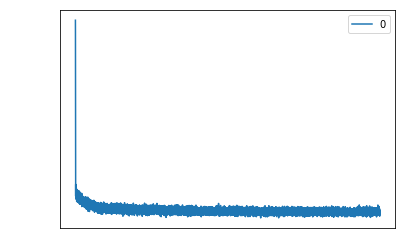

In [8]:
pd.DataFrame(losses).plot()
plt.tick_params(colors='white')

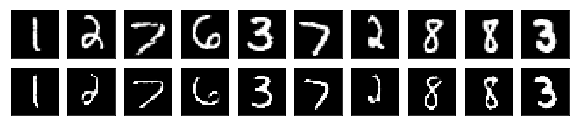

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 3))

model.eval()
for x, t in testloader:
    # original
    for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
        ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
        ax.imshow(im, 'gray')
    x = x.to(device)
    t = t.to(device)
    onehot = torch.LongTensor(len(x), 10).zero_().to(device)
    t = t.view(-1, 1)
    t = onehot.scatter(1, t, 1)
    # generate from x
    x = x.view(-1, 28 * 28)
    y, z = model(x, t)
    y = y.view(-1, 28, 28)
    for i, im in enumerate(y.cpu().detach().numpy()[:10]):
        ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
        ax.imshow(im, 'gray')
    break

In [10]:
z = torch.randn(20,10).to(device)
t = torch.tensor([5 if i<10 else 3 for i in range(20)]).to(device)
onehot = torch.LongTensor(20, 10).zero_().to(device)
t = t.view(-1, 1)
t = onehot.scatter(1, t, 1)

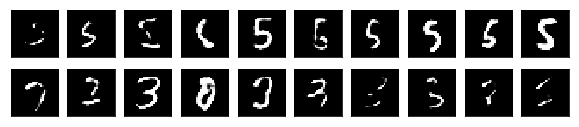

In [11]:
%matplotlib inline
fig = plt.figure(figsize=(10, 2))
x = model._decoder(z, t)
x = x.view(-1, 28, 28)
x = x.cpu().detach().numpy()
for i in range(20):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    ax.imshow(x[i], 'gray')